# Graph Convolutional Networks for Fraud Detection of Bitcoin Transactions

## Summary

Detecting fraudulent transactions is essential in keeping financial systems trustworthy. Traditionally, fraud detection is done through the analysis and vetting of carefully engineered features of individual transactions or of the individual entities involved(companies, accounts, individuals). Here I illustratre an end-to-end approach of node classification by graph neural networks to identify suspicious transactions. I compare my results on the elliptic dataset with the available literature and propose further ideas to be explored in the future.

## tl;dr
I trained 4 different types of models to classify bitcoin transactions. For each, two versions of the feature set were used: _all features_ (local + neighborhood-aggregated) and _only local features_ (without neighborhood information). 
* The best model was a Random Forest trained with all features: its performance was impaired when the aggregated features were removed. 
* The best graph-based neural network model was APPNP and its performance was better when only local features were used. APPNP performed better than an MLP with comparable complexity, indicating that the graph structure information gave it an advantage. 
* Finally, the best GCN model required using all features and several strategies to reduce overfitting. 

The excellent performance of a Random Forest shows that it makes sense to consider simple models when faced with a new task. It also indicates that the individual node features in the Elliptic dataset are already informative enough to make good predictions. It would be interesting to explore how the model performs, when fewer samples and/or features are available for training.

A shallow GCN with 2 layers might not be a good choice for node classification of a graph as sparse as the bitcoin transaction graph. If a node has few incoming edges, a graph convolution may not have enough neighbors with features to aggregate.

An interesting solution is provided by the APPNP model, which combines message passing with the teleportation principle of personalized pagerank. The long-range (20 iterations in the best model) of the predictions propagation through the network is an aspect that deserves further attention in the future.

The main performance metrics for comparison were:

|Model |Features |Dropout|Precision | Recall | F1 score|
|---|---|---:|---:|---:|---:|
|GCN|all|0.5|0.8051|0.4958|0.6137|
|GCN|local|0.|0.6667|0.4617|0.5456|
|APPNP|all|0.2|0.7791|0.6251|0.6936|
|APPNP|local|0.|**0.8158**|**0.6787**|**0.7409**|
|MLP|all|0.2|0.6538|0.6593|0.6565|
|MLP|local|0.|0.7799|0.6740|0.7231|
|RandomForest|all| | **0.9167**| **0.7211**| **0.8072**|
|RandomForest|local| | 0.8749| 0.7036| 0.7799|

**Disclaimer:** This was a hobby project done mostly nocturnally and on the weekends out of pure fascination for graph theory and neural networks. Although I made every effort to apply scientific rigor, these results constitute an initial exploration and should not be considered an exhaustive analysis. Importantly, due to the random nature of certain parameters (e.g. dropout), multiple repetitions of the experiments using different random seeds and/or different validation splits are necessary for a conclusive judgement.

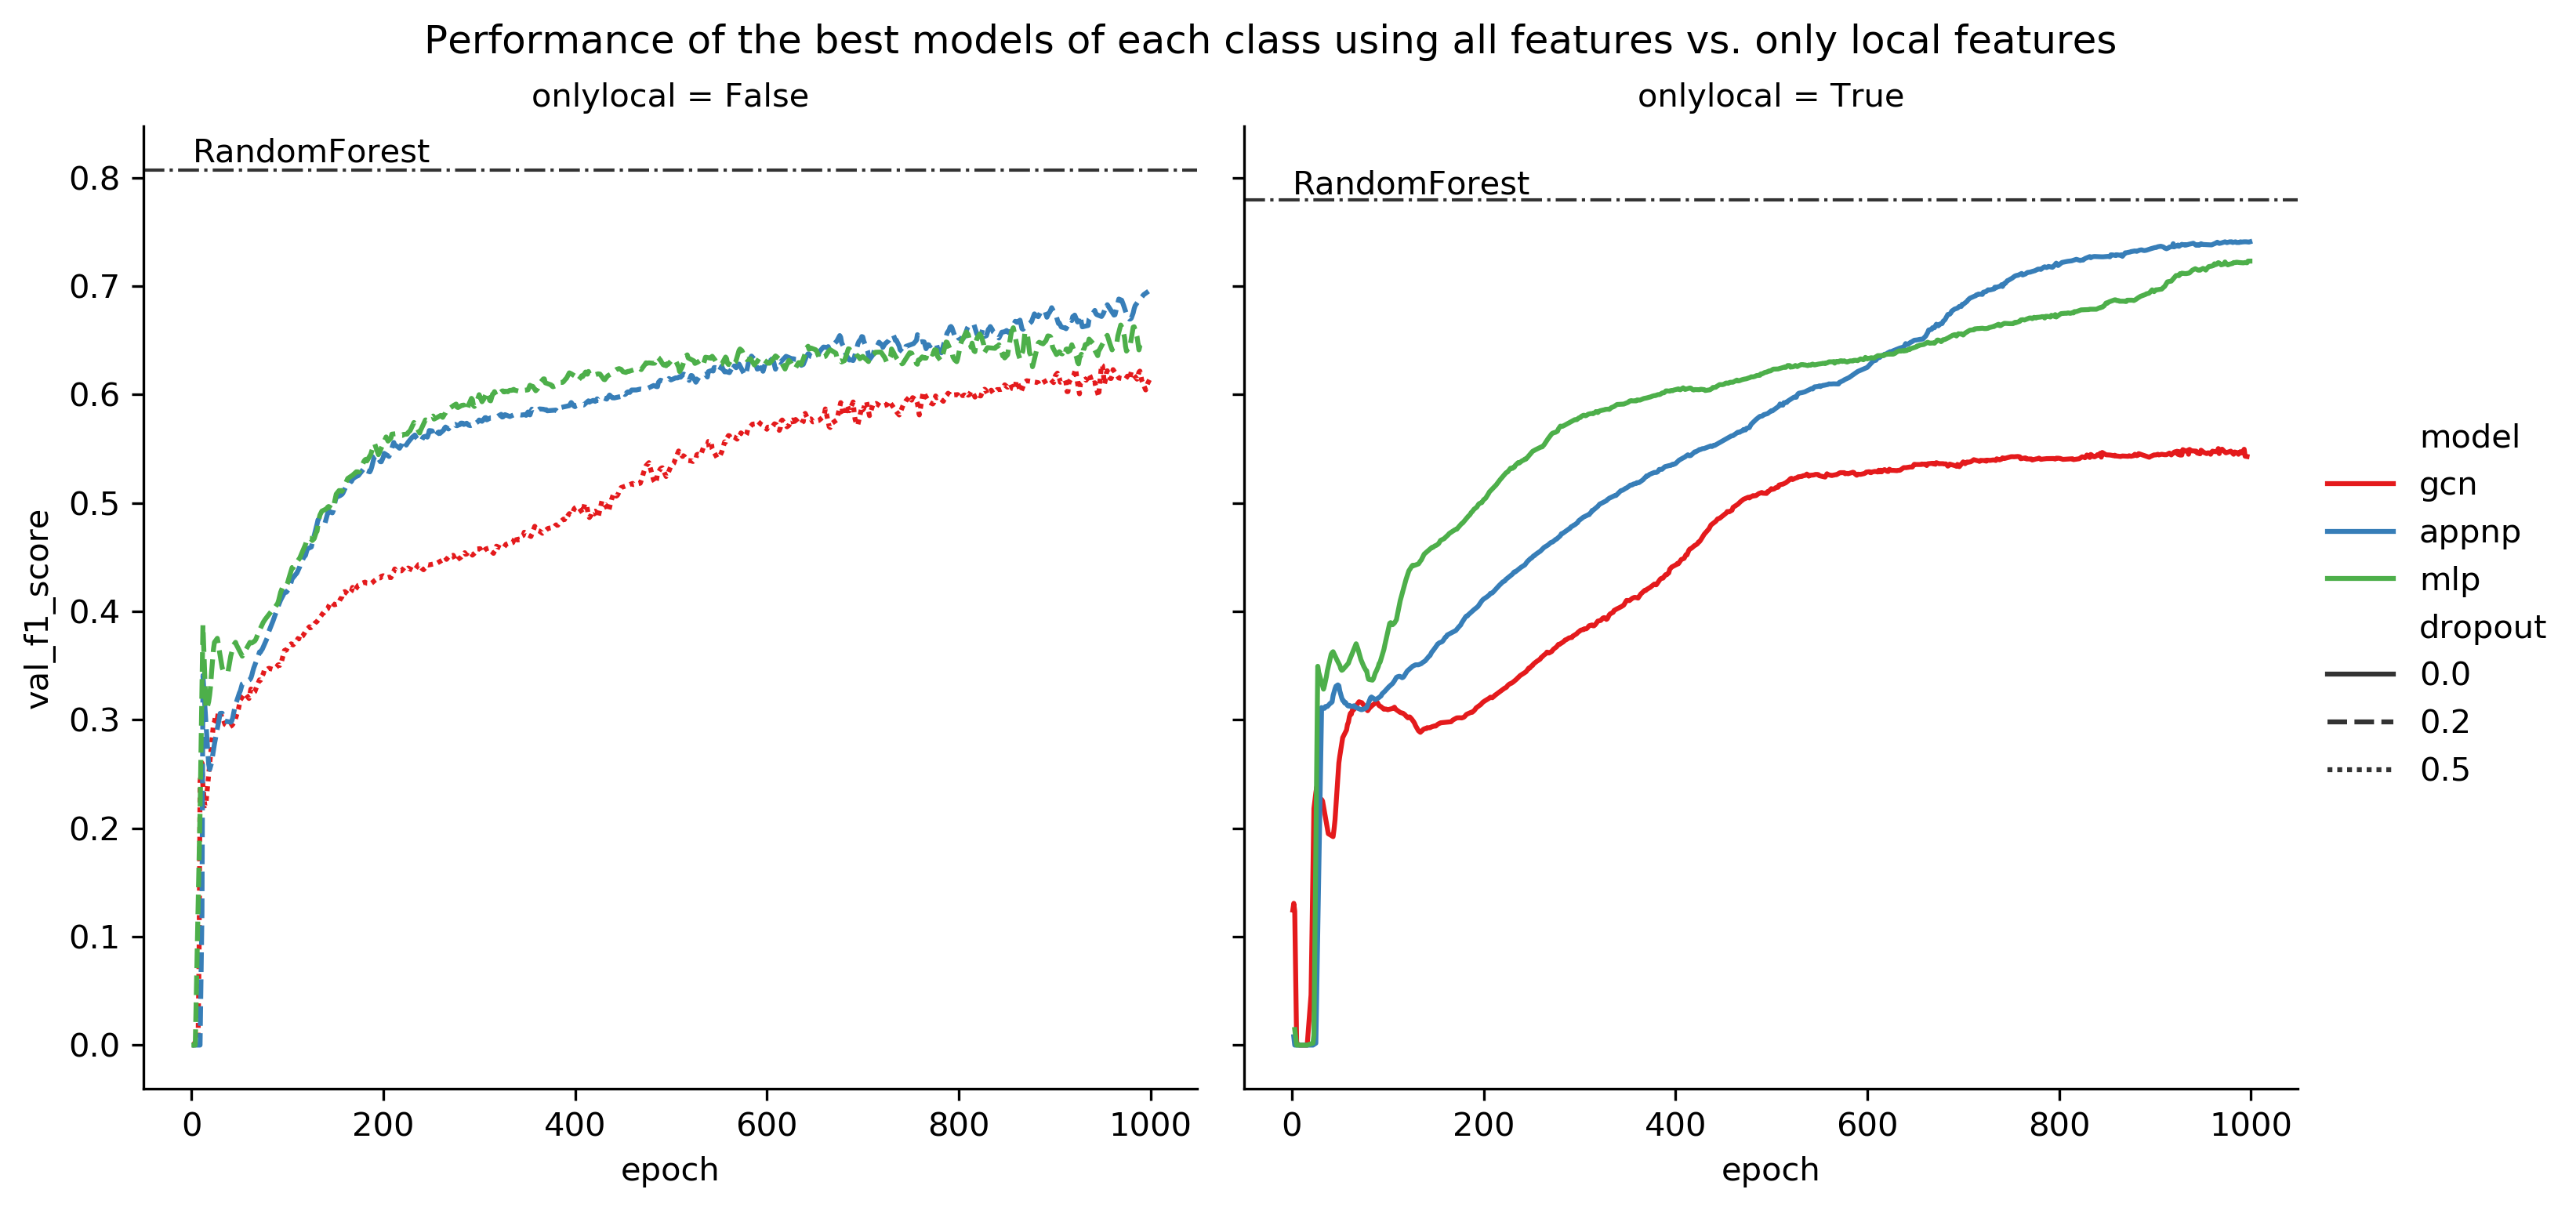

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300
path = os.path.realpath('.')
runs_config = pd.read_csv(path+'/experiments_summary.csv')
runs_metrics = pd.read_csv(path+'/experiments_metrics.csv')
runs = runs_metrics.merge(runs_config, left_on='name', right_on='name', suffixes=('','_'))
runs.rename(columns={'_step':'epoch'}, inplace=True)
runs['nobias'] = runs['nobias'].astype(str)
runs['dropout'] = runs['dropout'].astype(float)
runs['k'] = runs['k'].astype(str)
runs['alpha'] = runs['alpha'].astype(str)
runs.query('nhidden=="100" and _step_>=999.0', inplace=True)
query = '''((onlylocal==True and dropout==0) or (onlylocal==False  and (dropout==0.2 or dropout==0.5))) 
and ((model=="appnp" and k=="20.0" and alpha=="0.2" and (dropout==0. or dropout==0.2)) 
or (model=="mlp" and (dropout==0. or dropout==0.2)) 
or (model=="gcn"  and (dropout==0. or dropout==0.5))) 
and bidirectional==True and weight_decay==0.0005 and nobias=="False"'''.replace('\n',' ')
g1 = sns.relplot('epoch', 'val_f1_score', col='onlylocal', hue='model', style='dropout', palette=sns.color_palette("Set1", 3), kind='line', data=runs.query(query));
g1.axes.flat[0].axhline(0.8072, c='k', alpha=0.8, ls='-.', lw=1)
g1.axes.flat[0].text(1,0.815,'RandomForest')
g1.axes.flat[1].axhline(0.7799, c='k', alpha=0.8, ls='-.', lw=1)
g1.axes.flat[1].text(1,0.785,'RandomForest')
plt.suptitle('Performance of the best models of each class using all features vs. only local features', y=1.02);

## Content
1. [Introduction](#Introduction)
2. [Transaction data](#Transaction-data)
3. [Constructing the transaction graph](#Constructing-the-transaction-graph)
4. [Training a Graph Convolutional Network](#Training-a-Graph-Convolutional-Network)
5. [Additional experiments with GCNs](#Additional-experiments-with-GCNs)
6. [Random Forest benchmark](Random-Forest-benchmark)
7. [Long-range propagation of label predictions using APPNP](#Long-range-propagation-of-label-predictions-using-APPNP)

## Introduction
The [Elliptic Data Set](https://www.kaggle.com/ellipticco/elliptic-data-set) consists of anonymized transactions collected from the bitcoin exchange during 49 distinct time-periods. The transactions are represented as a graph containing 203769 nodes (transactions) and 234355 edges (bitcoin flow from one transaction to another). A subset of the transactions are labeled as licit or illicit. 
A detailed description of the dataset and an initial approach applying graph convolutional networks (GCNs) for the task of node classification has been addressed by:
> M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, ["Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics"](https://arxiv.org/abs/1908.02591), KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

In this notebook, I will take a closer look to how graph-based neural networks can be applied to this task and propose possible directions for future analyses.

Due to the longer training times and for reproducibility, the experiments were all run using the script in [models.py]() and all runs and metrics were tracked on [Weights&Biases](wandb.com). All results were exported to a csv file using [this script]() and loaded onto this notebook for visualization.

In [2]:
import os
import random
import time

import dgl
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300

# set random seeds
seed = 0
random.seed(seed)
np.random.seed(seed)
dgl.random.seed(seed)
torch.manual_seed(seed);

path = os.path.realpath('.')

In [3]:
# load experiment results exported from Weights&Biases
runs_config = pd.read_csv(path+'/experiments_summary.csv')
runs_metrics = pd.read_csv(path+'/experiments_metrics.csv')
runs = runs_metrics.merge(runs_config, left_on='name', right_on='name', suffixes=('','_'))
runs.rename(columns={'_step':'epoch'}, inplace=True)
runs['nobias'] = runs['nobias'].astype(str)
runs['dropout'] = runs['dropout'].astype(float)
runs['k'] = runs['k'].astype(str)
runs['alpha'] = runs['alpha'].astype(str)
runs.query('nhidden=="100" and _step_>=999.0', inplace=True)

## Transaction data
Three tables are initially available to download from Kaggle's dataset repository:
* An edgelist: the edges between bitcoin transactions (nodes identified by transaction id) necessary to build the graph
* A classes table: label for each transaction can be licit, illicit, or unknown
* A features table with 167 columns
 * Transaction id
 * Timestep: consecutive periods of time for which all bitcoin flows are translated to edges in a graph Edges exist only between transactions within the same timestep
 * 93 local features, i.e. intrinsic properties of the transactions themselves such as amount, transaction fee, etc.
 * 72 aggregated features with information about the immediate neighborhood of each node, e.g. sum of amounts of the neighboring transactions

In [4]:
# load data
df_edges = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_features = pd.read_csv(
    path + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None
)

# rename the classes to ints that can be handled by pytorch as labels
df_classes["label"] = df_classes["class"].replace(
    {"unknown": -1,  # unlabeled nodes
     "2": 0,  # labeled licit nodes
     #"1": 1,  # labeled illicit nodes
    }
).astype(int)

# rename features according to data description in paper
rename_dict = dict(
    zip(
        range(0, 167),
        ["txId", "time_step"]
        + [f"local_{i:02d}" for i in range(1, 94)]
        + [f"aggr_{i:02d}" for i in range(1, 73)],
    )
)
df_features.rename(columns=rename_dict, inplace=True)

In [5]:
# check missing data
print(f"Number of missing data points: {df_features.isna().sum().sum()+df_classes.isna().sum().sum()}")
print(f"Number of nodes (transactions): {df_features['txId'].nunique()}")
print(f"Number of edges: {df_edges.shape[0]}")
print(f"Number of classes: {df_classes['class'].nunique()}")
print(f"Timesteps range from {df_features['time_step'].min()} to {df_features['time_step'].max()}")

Number of missing data points: 0
Number of nodes (transactions): 203769
Number of edges: 234355
Number of classes: 3
Timesteps range from 1 to 49


### Correlation analysis
Additionally, the dataset was analyzed using the handy pandas-profiling package. The complete script for the analysis is in [eda.py](), which generates [a detailed report]() including multiple correlations. The main findings from the report can be summarized as:
* 29 features are highly skewed
* 76 features are highly correlated to other features in the dataset (Spearman correlation coefficient $\rho > 0.90$)
    * 21 aggregated features are highly correlated to other aggregated features
    * 54 local features are highly correlated to other local features
    * time_step is highly correlated with aggr_43 ($\rho = 0.91$)

## Constructing the transaction graph
We now have our data prepared in table format, but we want to be able to work on the graph constructed from the data. In order to create our transaction graph, we use the networkx package. We create a directed multigraph (a directed graph that allows for multiple edges between two nodes) and add the label attribute to each transaction.

In [6]:
# create networkx graph from the pandas dataframes
g_nx = nx.MultiDiGraph()
g_nx.add_nodes_from(
    zip(df_classes["txId"], [{"label": v} for v in df_classes["label"]])
)
g_nx.add_edges_from(zip(df_edges["txId1"], df_edges["txId2"]));

In [7]:
print(f"Graph with {g_nx.number_of_nodes()} nodes and {g_nx.number_of_edges()} edges.")
print(f"Number of connected components: {len(list(nx.weakly_connected_components(g_nx)))}")

Graph with 203769 nodes and 234355 edges.
Number of connected components: 49


We can confirm that there are 49 connected components (weakly connected compoments in the case of directed graphs) was constructed for each timestep. This means that the dataset consists of 49 different subgraphs, each corresponding to one timestep.

In [8]:
# create list of graphs, one for each timestep
components = list(nx.weakly_connected_components(g_nx))
g_nx_t_list = [g_nx.subgraph(components[i]) for i in range(0,len(components))]

/anaconda3/envs/dgl/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/dgl/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


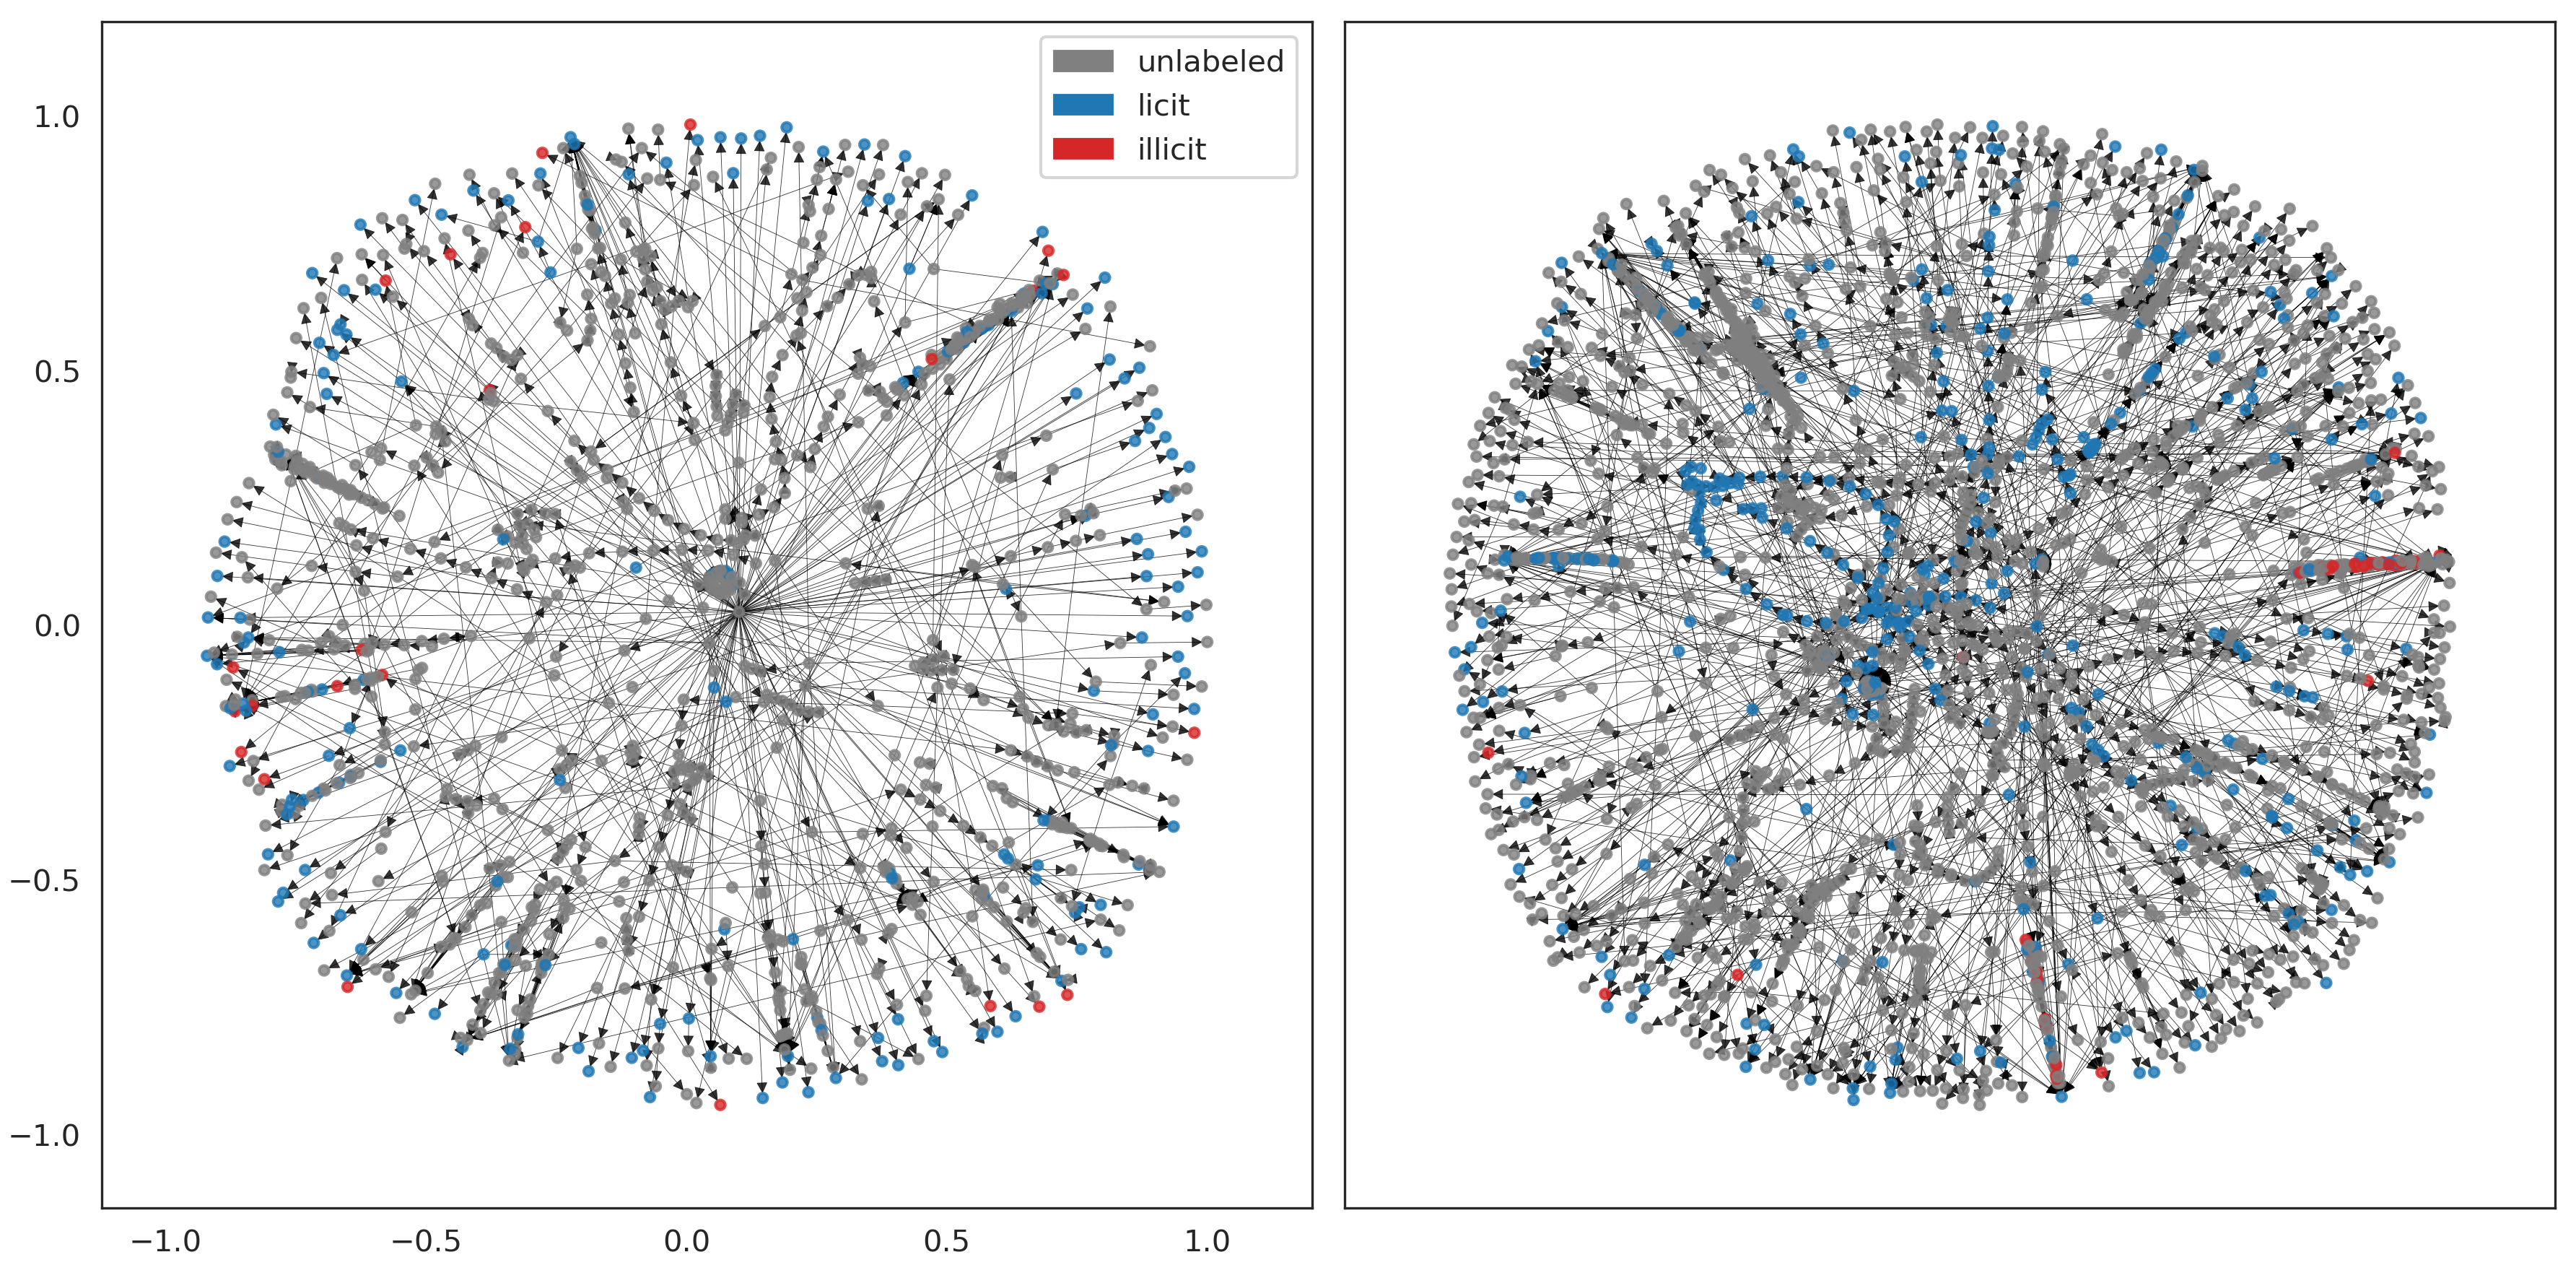

In [9]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    for i,t in enumerate([26,48]):
        node_label = list(nx.get_node_attributes(g_nx_t_list[t], 'label').values())
        mapping = {-1:'grey', 0:'C0', 1:'C3'}
        node_color = [mapping[l] for l in node_label]
        nx.draw_networkx(g_nx_t_list[t], node_size=10, node_color=node_color, with_labels=False, width=0.2, alpha=0.8, arrowsize=8, ax=ax[i])
    leg = ax[0].legend(['unlabeled', 'licit', 'illicit'])
    leg.legendHandles[0].set_color('grey')
    leg.legendHandles[1].set_color('C0')
    leg.legendHandles[2].set_color('C3')
    plt.tight_layout()

We can see that most of the transactions are not labeled and that only a minority of the labeled nodes correspond to illicit transactions. Moreover, there graph does not seem to be particularly dense. There seem to be chains of transactions one after the other. Also, many of these chains seem to concentrate one type of labeled transaction: either licit or illicit. Finally, a minority of nodes seems to have a larger number of edges, connecting with transactions in multiple chains or further away from their inmediate neighborhood.

### Graph metrics
We can calculate selected graph metrics to better quantify some important structural properties of the transaction graph.

In [10]:
g_metrics = {}
g_metrics['timestep'] = np.arange(1,50)
g_metrics['number_of_nodes'] = [graph.number_of_nodes() for graph in g_nx_t_list]
g_metrics['avg_degree'] = [np.mean(list(dict(nx.degree(graph)).values())) for graph in g_nx_t_list]
g_metrics['density'] = [nx.density(graph) for graph in g_nx_t_list]
g_metrics['avg_clustering'] = [nx.average_clustering(nx.DiGraph(graph)) for graph in g_nx_t_list]
g_metrics['avg_shortest_path'] = [nx.average_shortest_path_length(nx.DiGraph(graph)) for graph in g_nx_t_list]

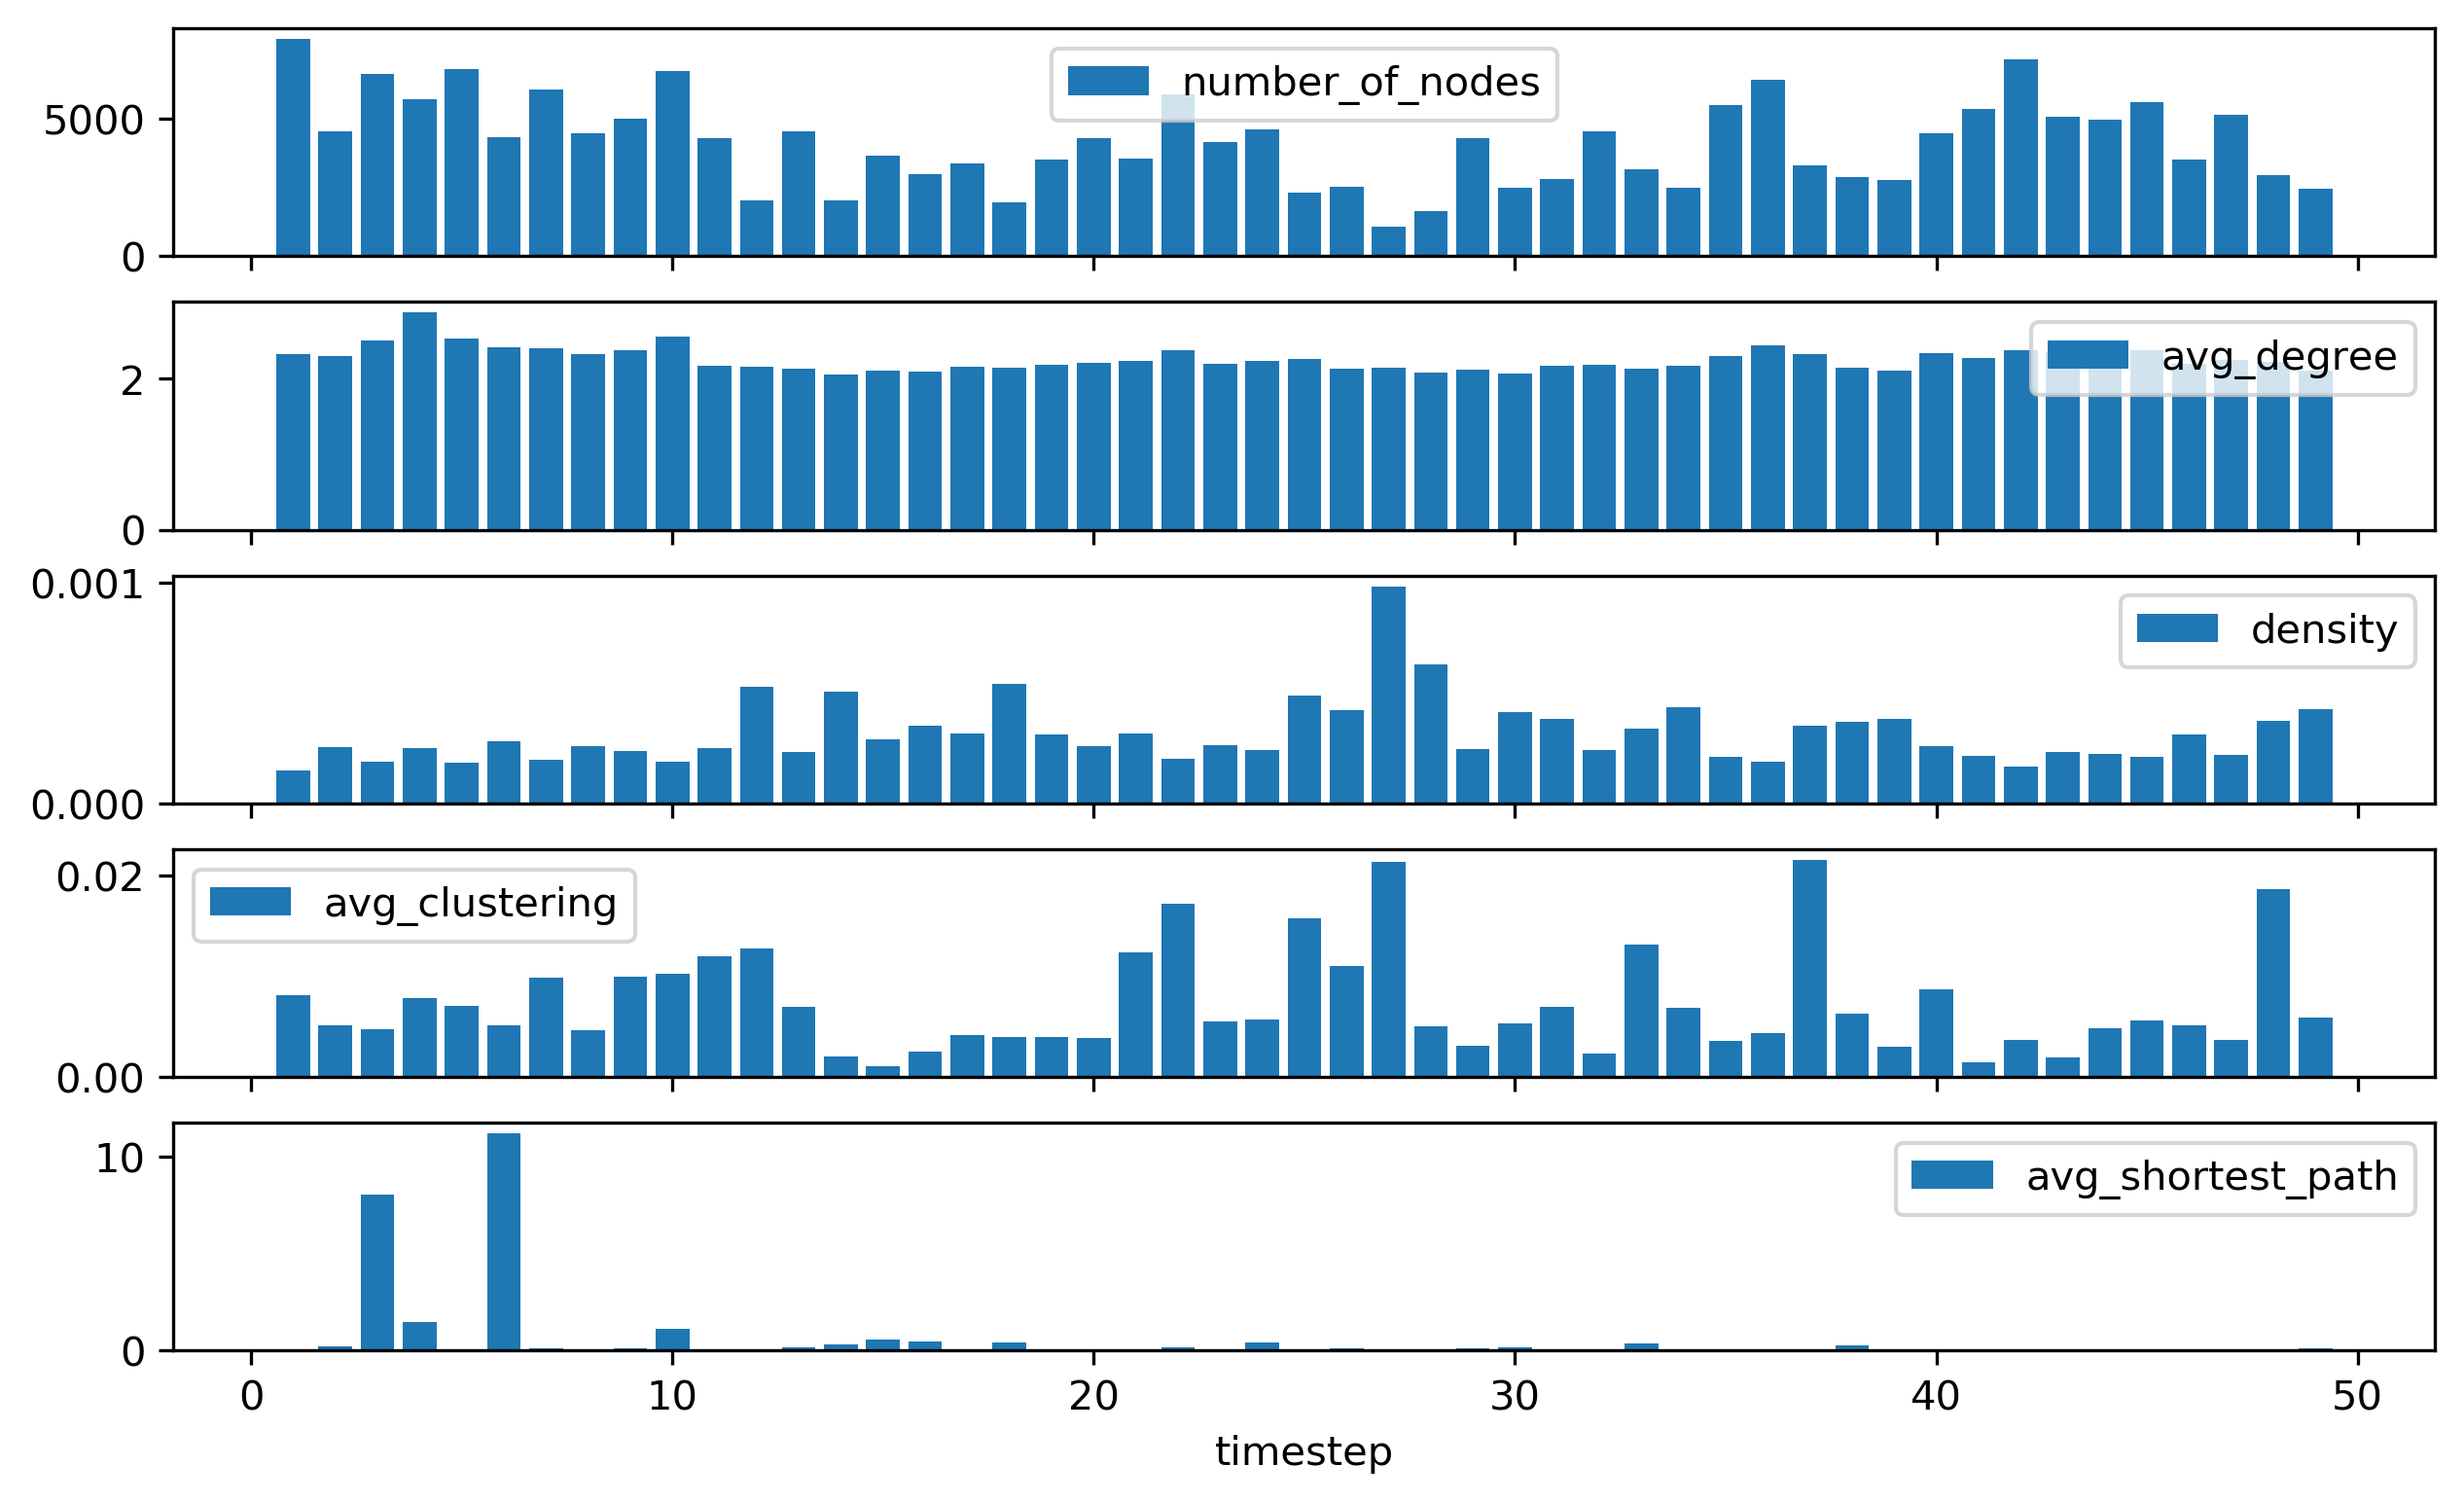

In [11]:
fig, ax = plt.subplots(len(g_metrics)-1,1, figsize=(10,6), sharex=True)
for i,label in enumerate(list(g_metrics.keys())[1:]):
    ax[i].bar(g_metrics['timestep'], g_metrics[label], label=label)
    ax[i].legend()
plt.xlabel('timestep');

In [12]:
print(f"Average density of the graphs across all timesteps: {np.mean(g_metrics['density']):.6f}")
print(f"Average degree of all nodes across all timesteps: {np.mean(list(dict(nx.degree(g_nx)).values())):.2f}")

Average density of the graphs across all timesteps: 0.000318
Average degree of all nodes across all timesteps: 2.30


Given the density of the transaction graph, it seems to be rather sparse. The average density accross all timesteps lies around 0.0003177 and each node has an average of 2.30 edges. In comparison, the Cora dataset (popularly used as a benchmark of node classification algorithms) has an average degree of 3.90 and a density of 0.0014812. With only 2708 nodes, Cora is a much smaller and denser graph.

## Training a Graph Convolutional Network
To build and train the GCN, I used [DGL](https://dgl.ai) as a framework for deep learning on graphs DGL is based on pytorch and uses DGLGraph objects that can be easily created from networkx graphs. Moreover, several implementations of graph-based neural layers are available in DGL.

### Graph creation
First we create the DGLGraph from a networkx Graph. We also add the label information as a tensor to the node data in the DGLGraph (from now on simply "graph"). Similarly, we add the node feature matrix to the graph as a tensor of shape (number of nodes, number of features) = (203769, 166).

Importantly, I tested the performance of the GCN using two options for constructing the graph: 
* Unidirectional edges: edges going from one transaction to the next. In a GCN, this would mean that information used by the model to classify nodes would flow in one direction (downstream) only. In this case, we use `g_nx` directly.
* Bidirectional edges: edges are made bidirectional, which would allow information flow in a GCN to travel in both directions (downstream and upstream). In this case, we use `g_nx.to_undirected().to_directed()`, i.e. we first make the edges undirected, and then back again directed. By doing so, networkx makes the edges in the resulting graph bidirectional.

It is not explicitely stated in the paper, which of these two options was used by Weber et al. However, from the performance metrics, it is likely that they used the bidirectional edges version.

In [13]:
# create unidirectional graph
g = dgl.DGLGraph()
g.from_networkx(g_nx)
g.ndata["label"] = torch.tensor(
    df_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"].values
)
g.ndata["features_matrix"] = torch.tensor(
    df_features.set_index("txId").loc[sorted(g_nx.nodes()), :].values
)
print(g)

DGLGraph(num_nodes=203769, num_edges=234355,
         ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
         edata_schemes={})


In [14]:
# make unidirectional edges bidirectional in networkx
g_nx_bidirectional = g_nx.to_undirected().to_directed()

# create bidirectional graph
g_bi = dgl.DGLGraph()
g_bi.from_networkx(g_nx_bidirectional)
g_bi.ndata["label"] = torch.tensor(
    df_classes.set_index("txId").loc[sorted(g_nx.nodes()), "label"].values
)
g_bi.ndata["features_matrix"] = torch.tensor(
    df_features.set_index("txId").loc[sorted(g_nx.nodes()), :].values
)
print(g_bi)

DGLGraph(num_nodes=203769, num_edges=468710,
         ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
         edata_schemes={})


### Graph normalizaiton
The performance of the GCN benefits from using a normalized version of the adjacency matrix. I applied a common normalization approach used in the literature. It starts by adding a self-loop to each node, which is the equivalent of adding the identity matrix to the adjacency matrix A $$\tilde{A} = A + I$$

The rest of the normalization consists of obtaining the normalized graph Laplacian ([here is a great overview](https://samidavies.wordpress.com/2016/09/20/whats-up-with-the-graph-laplacian/) explaining what the Laplacian means), which can be calculated as
$$\hat{A} = D^{-1/2}\tilde{A}D^{-1/2}$$ where $D$ is a matrix whose diagonal contains the degree of each node of $\tilde{A}$.

This matrix multiplication notation effectively means that the normalized Laplacian can have as a value in each $(i,j)$ position:
$$\hat{A}(i,j) = \begin{cases}
1 & \text{if $i=j$} \\[2ex]
{-1 \over {\sqrt{\deg(i)\deg(j)}}} & \text{if $i \neq j$ and $(i,j) \in E$},\\[2ex]
0 & \text{otherwise}
\end{cases}$$ where $E$ is the set of edges of the graph. As we can see, nodes with an (in)degree of zero could be troublesome, which is why we add the self-loops.


In [15]:
# add self loop
g.add_edges(g.nodes(), g.nodes())
print(g)

# add self loop to the bidirectional edges graph
g_bi.add_edges(g_bi.nodes(), g_bi.nodes())
print(g_bi)

DGLGraph(num_nodes=203769, num_edges=438124,
         ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
         edata_schemes={})
DGLGraph(num_nodes=203769, num_edges=672479,
         ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'features_matrix': Scheme(shape=(166,), dtype=torch.float64)}
         edata_schemes={})


### Train/validation data splitting
Now that our graph is ready, we need to split our data into training and validation sets. We will follow the same approach taken by Weber et al., which consists in a time-based split using the initial 70% of the timesteps to train the model and the remaining 30% for validation. This temporal split makes sense in the context of possible applications of such a model. A company could continuosly use their older historical data and labels for training and then predict the node classes for more recent transactions.

In [16]:
features = g.ndata["features_matrix"].float()
labels = g.ndata["label"].long()  # format required for cross entropy loss
in_feats = features.shape[1]
n_classes = 2  # licit or illicit (unknown label is ignored)
n_edges = g.number_of_edges()

dataset_size = df_classes["label"].notna().sum()
train_ratio = 0.7
train_time_steps = round(len(np.unique(features[:, 0])) * train_ratio)
shutdown_timestep = 43
train_indices = (
    ((features[:, 0] <= train_time_steps) & (labels != -1)).nonzero().view(-1)
)
val_indices = (
    ((features[:, 0] > train_time_steps) & (labels != -1)).nonzero().view(-1)
)
# timestep_indices = {
#     t:(
#     ((features[:, 0] == t) & (labels != -1)).nonzero().view(-1)
# ) for t in range(train_time_steps+1,50)
# }

print(f"""Number of timesteps used for training: {train_time_steps}
Number of timesteps used for validation: {dataset_size-train_time_steps}""")

Number of timesteps used for training: 34
Number of timesteps used for validation: 203735


### GCN model architecture

For the GCN model, I used the implementation from DGL, which is based on [the original implementation used by Kipf et al. (2016)](https://arxiv.org/abs/1609.02907). In short, the algorithm is given by the formula 

$$H^{(l+1)} = \sigma (D^{-1/2}\tilde{A}D^{-1/2}H^{(l)}W^{(l)})$$ 

where $\sigma$ is the activation function (ReLu), $D^{-1/2}\tilde{A}D^{-1/2}$ is the normalized graph Laplacian, $H^{(l)}$ are the logits  and $W^{(l)}$ are the learnable weights of the $l$th layer of the neural network. It is also possible to add a learnable bias to each layer. There are [some very good](https://tkipf.github.io/graph-convolutional-networks/) [explanations](https://arxiv.org/abs/1901.00596) of how this algorithm works available for reference.

In [17]:
class GCN(nn.Module):
    def __init__(
        self, g, in_feats, n_hidden, n_classes, n_layers, activation, dropout, bias
    ):
        super(GCN, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(
            GraphConv(in_feats, n_hidden, activation=activation, bias=bias)
        )
        # hidden layers
        for _ in range(n_layers - 2):
            self.layers.append(
                GraphConv(n_hidden, n_hidden, activation=activation, bias=bias)
            )
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes, bias=bias))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        return h


# utility function to evaluate the model
def evaluate(model, loss_fcn, features, labels, mask):
    """Calculate the loss, accuracy, precision, recall and f1_score for the masked data"""
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        loss = loss_fcn(logits, labels)
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        p, r, f, _ = precision_recall_fscore_support(labels, indices)
        return loss, correct.item() * 1.0 / len(labels), p[1], r[1], f[1]
    

# utility function to obtain a confusion matrix
def eval_confusion_matrix(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
    print(confusion_matrix(labels, indices))

### Model training
Now we can train the model using the specifications from the paper by Weber et al.:
* cross entropy loss function putting higher weight for the positive (illicit) samples: 0.7 positive vs 0.3 negative
* adam optimizer with learning rate `1e-3`
* no weight decay is mentioned
* no bias is mentioned
* no dropout
* train for 1000 epochs
* two Graph Convolutional layers with 100 and 2 neurons respectively

We can now define the Graph Convolutional Network architecture using DGL. In this case, it consists of `n_layers` GCN layers with `n_hidden` hidden units per layer:

In [18]:
# train and evaluate the model

def train_eval_model(model_class, g, features, **params):
    
    #bidirectional = params["bidirectional"] if "bidirectional" in params else None
    in_feats = features.shape[1]
    n_classes = 2
    n_hidden = params["n_hidden"]
    n_layers = params["n_layers"]
    weight_decay = params["weight_decay"]
    bias = params["bias"]
    dropout = params["dropout"]
    epochs = params["epochs"]
    lr = params["lr"]
    posweight = params["posweight"]
    
    model = model_class(g, in_feats, n_hidden, n_classes, n_layers, F.relu, dropout, bias)

    # weighted cross entropy loss function
    loss_fcn = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([1 - posweight, posweight])
    )

    # use optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    dur = []
    metrics = {"loss":{"train": [], "val": []},
               "accuracy":{"train": [], "val": []},
               "precision":{"train": [], "val": []},
               "recall":{"train": [], "val": []},
               "f1_score":{"train": [], "val": []},
              }

    for epoch in range(epochs):
        model.train()
        if epoch >= 3:
            t0 = time.time()
        # forward pass
        logits = model(features)
        loss = loss_fcn(logits[train_indices], labels[train_indices])
        metrics["loss"]["train"].append(loss)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # duration
        if epoch >= 3:
            dur.append(time.time() - t0)
        # evaluate on training set
        _, train_acc, train_precision, train_recall, train_f1_score = evaluate(
            model, loss_fcn, features, labels, train_indices
        )
        metrics["accuracy"]["train"].append(train_acc)
        metrics["precision"]["train"].append(train_precision)
        metrics["recall"]["train"].append(train_recall)
        metrics["f1_score"]["train"].append(train_f1_score)
        # evaluate on validation set
        val_loss, val_acc, val_precision, val_recall, val_f1_score = evaluate(
            model, loss_fcn, features, labels, val_indices
        )
        metrics["loss"]["val"].append(val_loss)
        metrics["accuracy"]["val"].append(val_acc)
        metrics["precision"]["val"].append(val_precision)
        metrics["recall"]["val"].append(val_recall)
        metrics["f1_score"]["val"].append(val_f1_score)
        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch:05d} | Time(s) {np.mean(dur):.2f} | val_loss {val_loss.item():.4f} "
                f"| Precision {val_precision:.4f} | Recall {val_recall:.4f} | Acc {val_acc:.4f} "
                f"| F1_score {val_f1_score:.4f}"
            )

    print("Confusion matrix:")
    eval_confusion_matrix(model, features, labels, val_indices)
    return model, metrics

In [ ]:
# GCN model parameters
params = {
    "n_hidden" : 100,
    "n_layers" : 2,
    "weight_decay" : 0.,
    "bias" : False,
    "dropout" : 0.,
    "epochs" : 1000,
    "lr" : 1e-3,
    "posweight" : 0.7,
}

# train on graph with unidirectional edges
model, metrics = train_eval_model(GCN, g, features, **params)

In [ ]:
# train on graph with bidirectional edges
model_bi, metrics_bi = train_eval_model(GCN, g_bi, features, **params)

In [ ]:
# plot the metrics during training
fig, ax = plt.subplots(1,3, figsize=(18,5), sharex=True)
ax[0].plot(metrics["loss"]['train'], label='unidir. train_loss', color='C0')
ax[0].plot(metrics["loss"]['val'], label='unidir. val_loss', color='C0', ls=':')
ax[1].plot(metrics['f1_score']['val'], label='unidir. val_f1_score', color='C0')
ax[2].plot(metrics['precision']['val'], label='unidir. val_precision', color='C0')
ax[2].plot(metrics['recall']['val'], label='unidir. val_recall', color='C0', ls=':')
ax[0].plot(metrics_bi["loss"]['train'], label='bidir. train_loss', color='C3')
ax[0].plot(metrics_bi["loss"]['val'], label='bidir. val_loss', color='C3', ls=':')
ax[1].plot(metrics_bi['f1_score']['val'], label='bidir. val_f1_score', color='C3')
ax[2].plot(metrics_bi['precision']['val'], label='bidir. val_precision', color='C3')
ax[2].plot(metrics_bi['recall']['val'], label='bidir. val_recall', color='C3', ls=':')
ax[0].legend()
ax[1].legend()
ax[2].legend();

Training the GCN model with these parameters led to a poorer performance than the one reported in the paper by Weber et al. The bidirectional graph variant produced the better results. Therefore it is also probably the setting used in the paper. Even though the Bitcoin flow from one transaction to another is intuitively one-directional, this would mean that, in a GCN, the information would only flow downstream. Having a bidirectional flow of information through the edges of the graph in the GCN makes information available to each node both upstream and downstream from it. This greatly improved the performance of the GCN.

|Model |Edges |Dropout|Description | Precision | Recall | F1 score|
|---|---|---:|---|---:|---:|---:|
|GCN (Weber et al.)||0.||0.812|0.512|0.628|
|GCN|unidirectional|0.||0.3764|0.3823|0.3793|
|GCN|bidirectional|0.||0.7860|0.3832|0.5152|

In order to figure out, whether there are additional parameters that I did not yet consider in replicating the GCN approach, I performed a series of experiments changing further training parameters and comparing the results. This, in turn, was useful in understanding in what ways the model could be modified to increase its performance.

## Additional experiments with GCNs


### Address overfitting by weight decay L2-regularization
One observation from the previous learning curves is that the validation loss starts to increase again after ca. 400 epochs, a clear sign of overfitting. One way to address this is to add dropout to the model. In this case, I added weight-decay L2-regularization to improve training. 

I further added a learnable bias to the GCN to see if this improved its performance (it did slightly). The other parameters were left intact.

In [ ]:
query = 'model=="gcn" and onlylocal==False and dropout=="0"'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
g = sns.relplot('epoch', 'train_loss', col='weight_decay', hue='bidirectional', style='nobias', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query));
plt.ylim(0,1);
g = sns.relplot('epoch', 'val_loss', col='weight_decay', hue='bidirectional', style='nobias', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query))
plt.ylim(0,1);

In [ ]:
query = 'model=="gcn" and onlylocal==False and dropout==0'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
sns.relplot('epoch', 'val_f1_score', col='weight_decay', hue='bidirectional', style='nobias', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query));

### Address overfitting by adding dropout
Another way to address this is to add dropout to the model. In this case, I added dropout before the second GCN layer (meaning that the inputs to the 2nd layer will be dropped out with a certain probability. Adding dropout considerably increased the precision, meaning that the model predicts far fewer false negatives. The recall, on the other hand, remains largely unchanged. The best model was obtained with a dropout $p = 0.5$

In [ ]:
query = 'model=="gcn" and bidirectional==True and onlylocal==False and nobias=="False" and weight_decay=="0.0005" and (dropout==0. or dropout==0.25 or dropout=="0.5")'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
fig, ax = plt.subplots(1,2, figsize=(12,5))
g1 = sns.relplot('epoch', 'val_loss', col='bidirectional', hue='dropout', kind='line', palette=sns.color_palette("Set1", 3), data=runs.query(query), ax=ax[0])
g2 = sns.relplot('epoch', 'train_loss', col='bidirectional', hue='dropout', kind='line', palette=sns.color_palette("Set1", 3), data=runs.query(query), ax=ax[1])
plt.close(g1.fig)
plt.close(g2.fig)
plt.legend(title='dropout', labels=['0.0', '0.25', '0.5'])
plt.setp(ax, ylim=(0,0.8));

In [ ]:
query = 'model=="gcn" and bidirectional==True and onlylocal==False and nobias=="False" and weight_decay=="0.0005" and (dropout==0. or dropout==0.25 or dropout=="0.5")'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
fig, ax = plt.subplots(1,3, figsize=(18,5))
g1 = sns.relplot('epoch', 'val_f1_score', col='bidirectional', hue='dropout', kind='line', palette=sns.color_palette("Set1", 3), data=runs.query(query), ax=ax[0])
g2 = sns.relplot('epoch', 'val_precision', col='bidirectional', hue='dropout', kind='line', palette=sns.color_palette("Set1", 3), data=runs.query(query), ax=ax[1])
g3 = sns.relplot('epoch', 'val_recall', col='bidirectional', hue='dropout', kind='line', palette=sns.color_palette("Set1", 3), data=runs.query(query), ax=ax[2])
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)
plt.legend(title='dropout', labels=['0.0', '0.25', '0.5']);

### Training a GCN with local features only
A question that arises from the paper is: how much does the graph-based information contribute to the performance of a GCN model compared to a more traditional non-graph-based approach?
Weber et al. show that the node embeddings that can be extracted from a GCN can help boost other traditional models. This makes sense intuitively: because of the networked nature of the bitcoin transactions, knowing the context or "neighborhood" of a transaction should add important information.

However, from the description of the Elliptic dataset we know that some of the features already contain information regarding the context of the transactions. In fact, 72 out of the 166 features are aggregated features. Therefore, I was curious to find out how would a GCN model perform with only the remaining 94 local features (including timestep) as inputs.

I modified the model to limit the set of features to only the local ones (including timestep). The input node features thus now have a shape of `(94,)`. This way we can assess the performance of a GCN without having to manually engineer features from their neighbors. In other words, we leave the feature engineering to the neural network itself.

In [ ]:
# consider only the first 94 features of the node feature matrix
features_local = g_bi.ndata["features_matrix"][:,0:94].float()

print(f"""Number of features (all): {features.shape[1]}""")
print(f"""Number of features (only local): {features_local.shape[1]}""")

In [ ]:
# GCN model parameters
#params = {
#    "bidirectional" : True,
#    "n_hidden" : 100,
#    "n_layers" : 2,
#    "weight_decay" : 5e-4,
#    "bias" : True,
#    "dropout" : 0.25,
#    "epochs" : 1000,
#    "lr" : 1e-3,
#    "posweight" : 0.7,
#}
#
#model, metrics = train_eval_model(GCN, g_bi, features_local, **params)

In [ ]:
query = 'model=="gcn" and bidirectional==True and weight_decay==0.0005 and nobias=="False" and (dropout==0 or dropout==0.25 or dropout==0.5)'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
sns.relplot('epoch', 'val_f1_score', col='onlylocal', hue='dropout', palette=sns.color_palette("Set1", 3), kind='line', data=runs.query(query));

We can see that the perfomance of the GCN improved by addition of dropout when all features were considered, but not when using only local features. This makes sense, as the aggregated features are likely less essential than the local ones.

## Random Forest benchmark

A sobering additional finding from the paper by Weber et al. was the out-of-the-box excellent performance of a simple Random Forest in correctly classifying the transactions as licit or illicit. I was able to replicate these results too for two different sets of features:
- All features
- Only local features

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# function to evaluate the model
def evaluate_rfc(model, features, labels, mask):
    """Calculate the loss, accuracy, precision, recall and f1_score for the masked data"""
    pred_rfc = model.predict(features[mask])
    labels = labels[mask]
    p, r, f, _ = precision_recall_fscore_support(labels, pred_rfc)
    return p[1], r[1], f[1]
    
# confusion matrix
def eval_confusion_matrix_rfc(model, features, labels, mask):
    pred_rfc = model.predict(features[mask])
    labels = labels[mask]
    print(confusion_matrix(labels, pred_rfc))

### Using all features (local + aggregated)

In [ ]:
rfc = RandomForestClassifier(n_estimators=50, max_features=50, random_state=seed)
rfc.fit(features[train_indices], labels[train_indices])
p, r, f1 = evaluate_rfc(rfc, features, labels, val_indices)
print(
    f"Precision {p:.4f} | Recall {r:.4f} | "
    f"F1 score {f1:.4f}"
)
print("Confusion matrix:")
eval_confusion_matrix_rfc(rfc, features, labels, val_indices)

The best results were obtained using as input all available features (local (including timestep) + aggregated). Both precision and recall of this model were high. This is confirmed by looking at the confusion matrix. The model predicts nearly no false positives and less than 30% of the illicit transactions are falsely labeled as negatives. It is a very good performance for such a simple model.

### Using local features only

In [ ]:
rfc_local = RandomForestClassifier(n_estimators=50, max_features=50, random_state=seed)
rfc_local.fit(features_local[train_indices], labels[train_indices])
p, r, f1 = evaluate_rfc(rfc_local, features_local, labels, val_indices)
print(
    f"Precision {p:.4f} | Recall {r:.4f} | "
    f"F1 score {f1:.4f}"
)
eval_confusion_matrix_rfc(rfc_local, features_local, labels, val_indices)

Removing the aggregated features from the input to the Random Forest (leaving other parameters equal) impairs its performance both in precision and recall, but not dramatically. It still is a very good model working out of the box. It makes sense that not having information about the immediate neighbors of a transaction would produce a worse-performing model.

### Comparison to GCN
So what do the resuls of the Random Forest tell us about GCNs and other deep learning techniques? Should we dismiss them and focus on simpler models instead? While this analysis shows that it pays to start simple and see how well we can tackle a task using classic machine learning methods first, there still are valid reasons why one should consider (graph) neural networks too.

0. Deep learning on graphs is cool!

Now, seriously,

1. There is information contained in the connections between data points, which is not being considered by a classical machine learning approach, unless carefully crafted features are available, which requires time and specific knowledge
2. The features available to a different dataset may be less informative than those in the Elliptic dataset, and therefore insufficient to produce a good-enough Random Forest model
3. There may even be situations when no intrinsic node features are available and we still want to be able to classify transactions. This would still be possible using a GCN but not with a Random Forest
4. Progress in unleashing the potential of GCNs can only be obtained by researching these networks

Now let's take a look at a different kind of graph-based model that, I figured, might be a good option for the bitcoin transaction classification task.

## Long-range propagation of label predictions using APPNP

Let's recapitulate. 
- We trained a complex GCN model to classify bitcoin transactions as licit or illicit and improved its performance by better parameters and training
- We found that a Random Forest model performed better than our complex GCN, almost effortlessly

Why is this? In order to look for the answer it pays to take a closer look at how the transaction graph is structured. Let's take for example the transactions of the last timestep.

In [ ]:
with sns.axes_style('white'):
    plt.figure(figsize=(8,6))
    node_label = list(nx.get_node_attributes(g_nx_t_list[49-1], 'label').values())
    mapping = {-1:'grey', 0:'C0', 1:'C3'}
    node_color = [mapping[l] for l in node_label]
    nx.draw_networkx(g_nx_t_list[49-1], node_size=10, node_color=node_color, with_labels=False, width=0.2, alpha=0.8, arrowsize=8)
    leg = plt.legend(['unlabeled', 'licit', 'illicit'])
    leg.legendHandles[0].set_color('grey')
    leg.legendHandles[1].set_color('C0')
    leg.legendHandles[2].set_color('C3')
    plt.show()

The original paper describing the GCN applied it to the node classification of papers in the Cora dataset. The bitcoin transaction graph is much larger and less dense than the Cora graph. One can hipothesize that for a denser graph with a higher average degree, each node could receive more information from its neighbors that would help make a GCN make a better prediction.

|Graph |Nodes |Density | Average degree|
|---|---:|---:|---:|
|Elliptic (bitcoin transactions)|203769|0.0003177|2.30|
|Cora (citations)|2708|0.0014812|3.90|

Furthermore, if we consider a simple chain of transactions (like the ones seen in the graph visualization), a node would receive information only from the previous node and pass it on only to the following node in the chain. In such a situation, it could be that the range of neighbors that feed the classification of any given node is too short and often not sufficient for a correct prediction. If this is the case, then considering a longer-ranging neighborhood could help train a better classification model.

## Approximated Personalized Propagation of Neural Predictions (APPNP)
Enter APPNP. [This model was recently proposed](https://arxiv.org/abs/1810.05997) as a way to reconcile the best of two worlds: neural message passing algorithms (in principle like the GCN), and personalized pagerank.

In **PageRank**, a measure of how central or important a node is calculated as a function of its connections and the importance of its neighbors. The pagerank $PR$ of a node $u$ is:

$$PR(u) = (1-d){1 \over {N}} + d \sum_{v \in \mathcal{N} (u)} {PR(v) \over D_{out}(v)}$$

where $N$ is the total number of nodes, $D_{out}$ is the outdegree, and $v$ is a node of the set of neighbors $\mathcal{N}$ of $u$. Pagerank ultimately requires each node to iteratively receive information from its neighbors until the pagerank stops changing and converges. The algorithm assigns a damping factor $d$, which can be understood by imagining a random surfer visiting nodes in the graph. The surfer would visit any given node moving along the edges of the graph until it reaches it with probability $d$. However, that surfer could also visit a node by randomly teleporting to it from elsewhere in the graph with probability $(1-d)$.

In **APPNP**, a multilayer perceptron takes the node features as input and outputs prediction probabilities $H^{0} = f_{MLP}(X)$. These are then propagated through graph for a $K$ number of iterations.

$$H^{t+1} = (1-\alpha)\left(\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{t}\right) + \alpha H^{0}$$

If you think the APPNP and the pagerank equations look similar is because they are. The teleportation probability $\alpha$ corresponds to the damping factor in pagerank. It tells us that for each iteration, the predictions for a node will depend on the normalized graph laplacian with probability $(1-\alpha)$ or on the output of the MLP with probability $\alpha$.

So how does do we train the APPNP model? I modified an implementation of an APPNP layer from DGL. In the [original paper by Klicpera et al. (2019)](https://arxiv.org/abs/1810.05997) they use an architecture consisting of a 2-layer MLP with 64 hidden units each, followed by the propagation component given by the APPNP equation. In order to use a comparable architecture to the GCN model, I decided to set the number of hidden units to 100 (same as previous section).

I tested several combinations of values for $K$ and $\alpha$. However, a more exhaustive hyperparameter search is needed to find the best possible configuration. Moreover, I used two versions of the feature set: all features vs. only local features.

The best F1 score was obtained for $K = 20$ propagation iterations and a teleportation probability $\alpha = 0.2$. Interestingly, the model trained with only local features performed better than using all features. Furthermore, the addition of dropout to the network had a positive effect when using all features, but a negative effect if only local features were considered. 

In [ ]:
class APPNP(nn.Module):
    def __init__(
        self,
        g,
        in_feats,
        n_hidden,
        n_classes,
        n_layers,
        activation,
        feat_drop,
        edge_drop,
        alpha,
        k,
    ):
        super(APPNP, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(nn.Linear(in_feats, n_hidden))
        # hidden layers
        for _ in range(n_layers - 2):
            self.layers.append(nn.Linear(n_hidden, n_hidden))
        # output layer
        self.layers.append(nn.Linear(n_hidden, n_classes))
        self.activation = activation
        if feat_drop:
            self.feat_drop = nn.Dropout(feat_drop)
        else:
            self.feat_drop = lambda x: x
        self.propagate = APPNPConv(k, alpha, edge_drop)
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, features):
        # prediction step
        h = features
        h = self.feat_drop(h)
        h = self.activation(self.layers[0](h))
        for layer in self.layers[1:-1]:
            h = self.activation(layer(h))
        h = self.layers[-1](self.feat_drop(h))
        # propagation step
        h = self.propagate(self.g, h)
        return h

In [ ]:
query = 'model=="appnp" and nhidden==100 and bidirectional==True and weight_decay==0.0005 and nobias=="False" and (dropout==0 or dropout==0.2 or dropout==0.25)'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
sns.relplot('epoch', 'val_f1_score', row='onlylocal', col='alpha', hue='k', style='dropout', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query));

### MLP benchmark

But just how much of an effect does the incorporation of the graph structure have on the performance of the model? How much of it is simply due to the MLP that is trained on top of the propagation phase of the APPNP? In order to assess this, I trained an MLP model with the same architecture and for the two different versions of the features set.

The results show that the APPNP model has a better F1 score than the MLP after 1000 epochs, both for the only local feature set and the full feature set. With respect to precision and F1 score, the addition of dropout was beneficial when using all features and prejudicial when using the local features only. In contrast, recall was slightly improved by adding dropout to both feature variants.

In [ ]:
class MLP(nn.Module):
    def __init__(
        self, in_feats, n_hidden, n_classes, n_layers, activation, feat_drop,
    ):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(nn.Linear(in_feats, n_hidden))
        # hidden layers
        for _ in range(n_layers - 2):
            self.layers.append(nn.Linear(n_hidden, n_hidden))
        # output layer
        self.layers.append(nn.Linear(n_hidden, n_classes))
        self.activation = activation
        if feat_drop:
            self.feat_drop = nn.Dropout(feat_drop)
        else:
            self.feat_drop = lambda x: x
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, features):
        # prediction step
        h = features
        h = self.feat_drop(h)
        h = self.activation(self.layers[0](h))
        for layer in self.layers[1:-1]:
            h = self.activation(layer(h))
        h = self.layers[-1](self.feat_drop(h))
        return h

In [ ]:
query = '((model=="appnp" and k=="20.0" and alpha=="0.2") or model=="mlp") and bidirectional==True and weight_decay==0.0005 and nobias=="False" and (dropout==0 or dropout==0.2)'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
sns.relplot('epoch', 'val_f1_score', col='onlylocal', hue='model', style='dropout', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query));

In [ ]:
query = '((model=="appnp" and k=="20.0" and alpha=="0.2") or model=="mlp") and bidirectional==True and weight_decay==0.0005 and nobias=="False" and (dropout==0 or dropout==0.2)'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
sns.relplot('epoch', 'val_precision', col='onlylocal', hue='model', style='dropout', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query));

In [ ]:
query = '((model=="appnp" and k=="20.0" and alpha=="0.2") or model=="mlp") and bidirectional==True and weight_decay==0.0005 and nobias=="False" and (dropout==0 or dropout==0.2)'
print(f"Plotting {runs.query(query)['name'].nunique()} runs: {runs.query(query)['name'].unique()}")
sns.relplot('epoch', 'val_recall', col='onlylocal', hue='model', style='dropout', palette=sns.color_palette("Set1", 2), kind='line', data=runs.query(query));

### Putting it all together
Please refer to my [tl;dr](#tl;dr) :)

In [ ]:
query = '''((onlylocal==True and dropout==0) or (onlylocal==False  and (dropout==0.2 or dropout==0.5))) 
and ((model=="appnp" and k=="20.0" and alpha=="0.2" and (dropout==0. or dropout==0.2)) 
or (model=="mlp" and (dropout==0. or dropout==0.2)) 
or (model=="gcn"  and (dropout==0. or dropout==0.5))) 
and bidirectional==True and weight_decay==0.0005 and nobias=="False"'''.replace('\n',' ')
g1 = sns.relplot('epoch', 'val_f1_score', col='onlylocal', hue='model', style='dropout', palette=sns.color_palette("Set1", 3), kind='line', data=runs.query(query));
g1.axes.flat[0].axhline(0.8072, c='k', alpha=0.8, ls='-.', lw=1)
g1.axes.flat[0].text(1,0.815,'RandomForest')
g1.axes.flat[1].axhline(0.7799, c='k', alpha=0.8, ls='-.', lw=1)
g1.axes.flat[1].text(1,0.785,'RandomForest')
plt.suptitle('Performance of the best models of each class using all features vs. only local features', y=1.02);